<div style="text-align: center; font-size: 21px; font-weight: bold; text-decoration: underline;">
    Prediction of future Amazon.com stock prices using Machine Learning algorithms
</div>

Contributors:
- Wiktoria Sarabon
- Martyna Szawłowska
- Magdalena Lamczyk
- Jakub Galikowski
- Natalia Szczepkowska

## Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping
from sklearn.datasets import make_regression
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

In [ ]:
def plot_actual_predicted(y_test, y_pred, title): 
    ticks = [y_test.index[i] for i in range (0, len(y_test)-1, 80)]
    ticks.append(y_test.index[len(y_test)-1])
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, color='green', label='Actual')
    plt.plot(y_pred, color='orange', label='Predicted')
    plt.grid(True)
    plt.xticks(ticks, fontsize=8)
    plt.xlabel('Date', fontsize = 9)
    plt.ylabel('Stock Price', fontsize=9)
    plt.title(title)
    plt.legend()
    plt.show()

## Data overview

In [2]:
data = pd.read_csv('data/final_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.set_index('Date', inplace=True)
data.head()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,SP100_Open,SP100_High,SP100_Low,SP100_Close,SP100_Volume,...,Revenue_Billions,GDP,CCI Total,CCI USA,CCI Europe,Unemployment_USA,BAC_Close,JPM_Close,Citigroup_Close,WFC_Close
Date,,,,,,,,,,,,,,,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1.443120e+09,410.994995,414.295013,409.625000,414.200012,9.163600e+08,...,0.064587,8518.825,101.3,102.0,100.8,4.9,30.7500,32.375000,186.666672,13.40625
1997-05-16,0.098438,0.098958,0.085417,0.086458,2.940000e+08,414.200012,414.200012,406.279999,406.279999,9.735600e+08,...,0.064948,8518.825,101.3,102.0,100.8,4.9,30.1875,31.208332,184.166672,13.12500
1997-05-19,0.088021,0.088542,0.081250,0.085417,1.221360e+08,406.279999,410.350006,406.279999,409.230011,6.902800e+08,...,0.066034,8518.825,101.3,102.0,100.8,4.9,29.6875,30.875000,185.833328,13.18750
1997-05-20,0.086458,0.087500,0.081771,0.081771,1.093440e+08,409.230011,414.480011,405.890015,414.160004,9.017000e+08,...,0.066395,8518.825,101.3,102.0,100.8,4.9,30.0625,32.166668,192.083328,13.40625
1997-05-21,0.081771,0.082292,0.068750,0.071354,3.770640e+08,414.160004,416.739990,411.035004,413.140015,1.081460e+09,...,0.066757,8518.825,101.3,102.0,100.8,4.9,29.2500,31.041668,186.250000,13.00000


In [3]:
data.tail()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,SP100_Open,SP100_High,SP100_Low,SP100_Close,SP100_Volume,...,Revenue_Billions,GDP,CCI Total,CCI USA,CCI Europe,Unemployment_USA,BAC_Close,JPM_Close,Citigroup_Close,WFC_Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-22,153.770004,154.350006,152.710007,153.419998,29480100.0,2231.229980,2240.580078,2222.189941,2230.479980,3.046770e+09,...,573.280822,27944.627,NaN,NaN,NaN,3.7,33.430000,167.399994,50.860001,49.180000
2023-12-26,153.559998,153.979996,153.029999,153.410004,25067200.0,2232.850098,2242.590088,2232.189941,2238.360107,2.513910e+09,...,573.947123,27944.627,NaN,NaN,NaN,3.7,33.860001,168.389999,51.340000,49.639999
2023-12-27,153.559998,154.779999,153.119995,153.339996,31434700.0,2237.899902,2243.959961,2236.330078,2241.699951,2.748450e+09,...,574.113699,27944.627,NaN,NaN,NaN,3.7,33.840000,169.399994,51.459999,49.330002
2023-12-28,153.720001,154.080002,152.949997,153.380005,27057000.0,2245.219971,2248.570068,2241.209961,2242.439941,2.698860e+09,...,574.280274,27944.627,NaN,NaN,NaN,3.7,33.880001,170.300003,51.520000,49.480000
2023-12-29,153.100006,153.889999,151.029999,151.940002,39789000.0,2243.270020,2245.399902,2226.860107,2236.189941,3.126060e+09,...,574.446849,27944.627,NaN,NaN,NaN,3.7,NaN,NaN,NaN,NaN


The dataset contains the following 24 columns:
- **Date**,
- **AMZN_Open**: The price at which the Amazon.com stock first traded upon the opening of the market (in USD),
- **AMZN_High**: The highest price at which the Amazon.com stock traded during the trading day (in USD),
- **AMZN_Low**: The lowest price at which the Amazon.com stock traded during the trading day (in USD),
- **AMZN_Close**: The price at which the Amazon.com stock last traded upon the closing of the market (in USD),
- **AMZN_Volume**: The total number of Amazon.com shares traded during the trading day (in USD),
- **SP100_Open**: The collective starting point of the stocks within the S&P 100 index (in USD),
- **SP100_High**: The peak level of the S&P 100 index's performance throughout the trading session (in USD),
- **SP100_Low**: The lowest point of the S&P 100 index's performance during the trading session (in USD),
- **SP100_Close**: The collective ending point of the stocks within the S&P 100 index (in USD),
- **SP100_Volume**: The overall level of activity and trading interest in the stocks comprising the S&P 100 index (in USD),
- **Inflation_USA**: Annual mean inflation rate in the USA (in %),
- **Inflation_UE**: Annual mean inflation rate in the European Union (in %),
- **Inflation_World**: Annual mean inflation rate in the world (in %),
- **Revenue_Billions**: Amazon.com revenue (in billions USD),
- **GDP**: Gross Domestic Product (in billions USD),
- **CCI Total**: Consumer Confidence Index in total (above 100 - consumers are willing to make future expenses/purchases; below 100 - consumers will limit their spending),
- **CCI USA**: Consumer Confidence Index in USA,
- **CCI Europe**: Consumer Confidence Index in Europe,
- **Unemployment_USA**: The unemployment rate in the USA (in %),
- **BAC_Close**: The price at which the Bank of America Corporation stock last traded upon the closing of the market (in USD),
- **JPM_Close**: The price at which the J.P. Morgan Chase & Co. stock last traded upon the closing of the market (in USD),
- **Citigroup_Close**: The price at which the Citigroup stock last traded upon the closing of the market (in USD),
- **WFC_Close**: The price at which the Wells Fargo & Company stock last traded upon the closing of the market (in USD).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6708 entries, 1997-05-15 to 2023-12-29
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AMZN_Open         6701 non-null   float64
 1   AMZN_High         6701 non-null   float64
 2   AMZN_Low          6701 non-null   float64
 3   AMZN_Close        6701 non-null   float64
 4   AMZN_Volume       6701 non-null   float64
 5   SP100_Open        6701 non-null   float64
 6   SP100_High        6701 non-null   float64
 7   SP100_Low         6701 non-null   float64
 8   SP100_Close       6701 non-null   float64
 9   SP100_Volume      6701 non-null   float64
 10  Inflation_USA     6701 non-null   float64
 11  Inflation_EU      6701 non-null   float64
 12  Inflation_World   6701 non-null   float64
 13  Revenue_Billions  6708 non-null   float64
 14  GDP               6708 non-null   float64
 15  CCI Total         6688 non-null   float64
 16  CCI USA           6688 non-null 

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AMZN_Open,6701.0,3.432438e+01,5.013650e+01,7.031300e-02,2.043000e+00,7.244000e+00,4.723750e+01,1.872000e+02
AMZN_High,6701.0,3.473663e+01,5.072325e+01,7.239600e-02,2.081500e+00,7.354500e+00,4.745250e+01,1.886540e+02
AMZN_Low,6701.0,3.387753e+01,4.949330e+01,6.562500e-02,1.998500e+00,7.176000e+00,4.658750e+01,1.848395e+02
AMZN_Close,6701.0,3.431570e+01,5.011010e+01,6.979200e-02,2.044500e+00,7.272500e+00,4.698950e+01,1.865705e+02
AMZN_Volume,6701.0,1.401413e+08,1.389811e+08,9.744000e+06,6.695890e+07,1.037740e+08,1.585660e+08,2.086584e+09
SP100_Open,6701.0,8.739697e+02,4.635779e+02,3.234700e+02,5.574700e+02,6.739700e+02,1.056800e+03,2.245220e+03
SP100_High,6701.0,8.794646e+02,4.660805e+02,3.309700e+02,5.608200e+02,6.790800e+02,1.059260e+03,2.248570e+03
SP100_Low,6701.0,8.681988e+02,4.610202e+02,3.173700e+02,5.535400e+02,6.687100e+02,1.054040e+03,2.241210e+03
SP100_Close,6701.0,8.741433e+02,4.637173e+02,3.221300e+02,5.575100e+02,6.741000e+02,1.056840e+03,2.242440e+03
SP100_Volume,6701.0,3.075967e+09,1.623774e+09,1.549000e+08,1.488800e+09,3.295600e+09,4.060340e+09,1.145623e+10


Number of unique values

In [6]:
data.nunique()

AMZN_Open           5967
AMZN_High           5926
AMZN_Low            5932
AMZN_Close          6067
AMZN_Volume         6508
SP100_Open          6429
SP100_High          6371
SP100_Low           6411
SP100_Close         6417
SP100_Volume        6510
Inflation_USA         27
Inflation_EU          26
Inflation_World       26
Revenue_Billions    6708
GDP                  107
CCI Total             57
CCI USA               65
CCI Europe            62
Unemployment_USA      65
BAC_Close           3750
JPM_Close           4513
Citigroup_Close     4234
WFC_Close           3556
dtype: int64

Number of missing records in each column

In [7]:
data.isnull().sum()

AMZN_Open            7
AMZN_High            7
AMZN_Low             7
AMZN_Close           7
AMZN_Volume          7
SP100_Open           7
SP100_High           7
SP100_Low            7
SP100_Close          7
SP100_Volume         7
Inflation_USA        7
Inflation_EU         7
Inflation_World      7
Revenue_Billions     0
GDP                  0
CCI Total           20
CCI USA             20
CCI Europe          20
Unemployment_USA     0
BAC_Close            8
JPM_Close            8
Citigroup_Close      8
WFC_Close            8
dtype: int64

In [8]:
null_data = data[data.isnull().any(axis=1)]
print(null_data)

             AMZN_Open   AMZN_High    AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                      
2000-12-31         NaN         NaN         NaN         NaN          NaN   
2005-12-31         NaN         NaN         NaN         NaN          NaN   
2006-12-31         NaN         NaN         NaN         NaN          NaN   
2011-12-31         NaN         NaN         NaN         NaN          NaN   
2016-12-31         NaN         NaN         NaN         NaN          NaN   
2017-12-31         NaN         NaN         NaN         NaN          NaN   
2022-12-31         NaN         NaN         NaN         NaN          NaN   
2023-12-01  146.000000  147.250000  145.550003  147.029999   39924600.0   
2023-12-04  145.250000  145.350006  142.809998  144.839996   48294200.0   
2023-12-05  143.550003  148.570007  143.130005  146.880005   46822400.0   
2023-12-06  147.580002  147.850006  144.279999  144.520004   39679000.0   
2023-12-07  146.149994  1

- Seven records are missing in the first 13 columns for December 31 in different years.
- There is no information about CCI in twenty days of December 2023.

Percentage of missing values in each column

In [9]:
(data.isnull().sum()/(len(data)))*100

AMZN_Open           0.104353
AMZN_High           0.104353
AMZN_Low            0.104353
AMZN_Close          0.104353
AMZN_Volume         0.104353
SP100_Open          0.104353
SP100_High          0.104353
SP100_Low           0.104353
SP100_Close         0.104353
SP100_Volume        0.104353
Inflation_USA       0.104353
Inflation_EU        0.104353
Inflation_World     0.104353
Revenue_Billions    0.000000
GDP                 0.000000
CCI Total           0.298151
CCI USA             0.298151
CCI Europe          0.298151
Unemployment_USA    0.000000
BAC_Close           0.119261
JPM_Close           0.119261
Citigroup_Close     0.119261
WFC_Close           0.119261
dtype: float64

- The 13 columns each have approximately 0.1% missing values.
- 0.3% of the values from the CCI columns are missing.

**Conclusion**: we can delete rows with missing values, the data is large, so it should not affect the results significantly.

Removing missing values from data

In [10]:
data = data.dropna()
data.isnull().sum()

AMZN_Open           0
AMZN_High           0
AMZN_Low            0
AMZN_Close          0
AMZN_Volume         0
SP100_Open          0
SP100_High          0
SP100_Low           0
SP100_Close         0
SP100_Volume        0
Inflation_USA       0
Inflation_EU        0
Inflation_World     0
Revenue_Billions    0
GDP                 0
CCI Total           0
CCI USA             0
CCI Europe          0
Unemployment_USA    0
BAC_Close           0
JPM_Close           0
Citigroup_Close     0
WFC_Close           0
dtype: int64

## Exploratory Data Analysis

### Histograms

In [11]:
def plot_histograms(df):
    num_cols = len(df.columns)
    num_rows = math.ceil(num_cols / 3)  # calculation of the number of rows

    plt.rcParams['figure.figsize'] = [15, 5 * num_rows]  # adjusting the size of the figure to the number of rows

    fig, ax = plt.subplots(num_rows, 3)

    for i, col_name in enumerate(df.columns):
        row = i // 3  # determining the row number
        col = i % 3   # determining the column number
        x = df[col_name]

        ax[row, col].hist(x, bins=100, color='teal')
        ax[row, col].set_title(col_name, fontsize=20)
        ax[row, col].set_xlabel('Value', fontsize=15)
        ax[row, col].set_ylabel('Frequency', fontsize=15)

    # removing unnecessary subplots
    for i in range(num_cols, num_rows * 3):
        row = i // 3
        col = i % 3
        fig.delaxes(ax[row, col])

    plt.tight_layout()  # spacing adjustment
    plt.show()


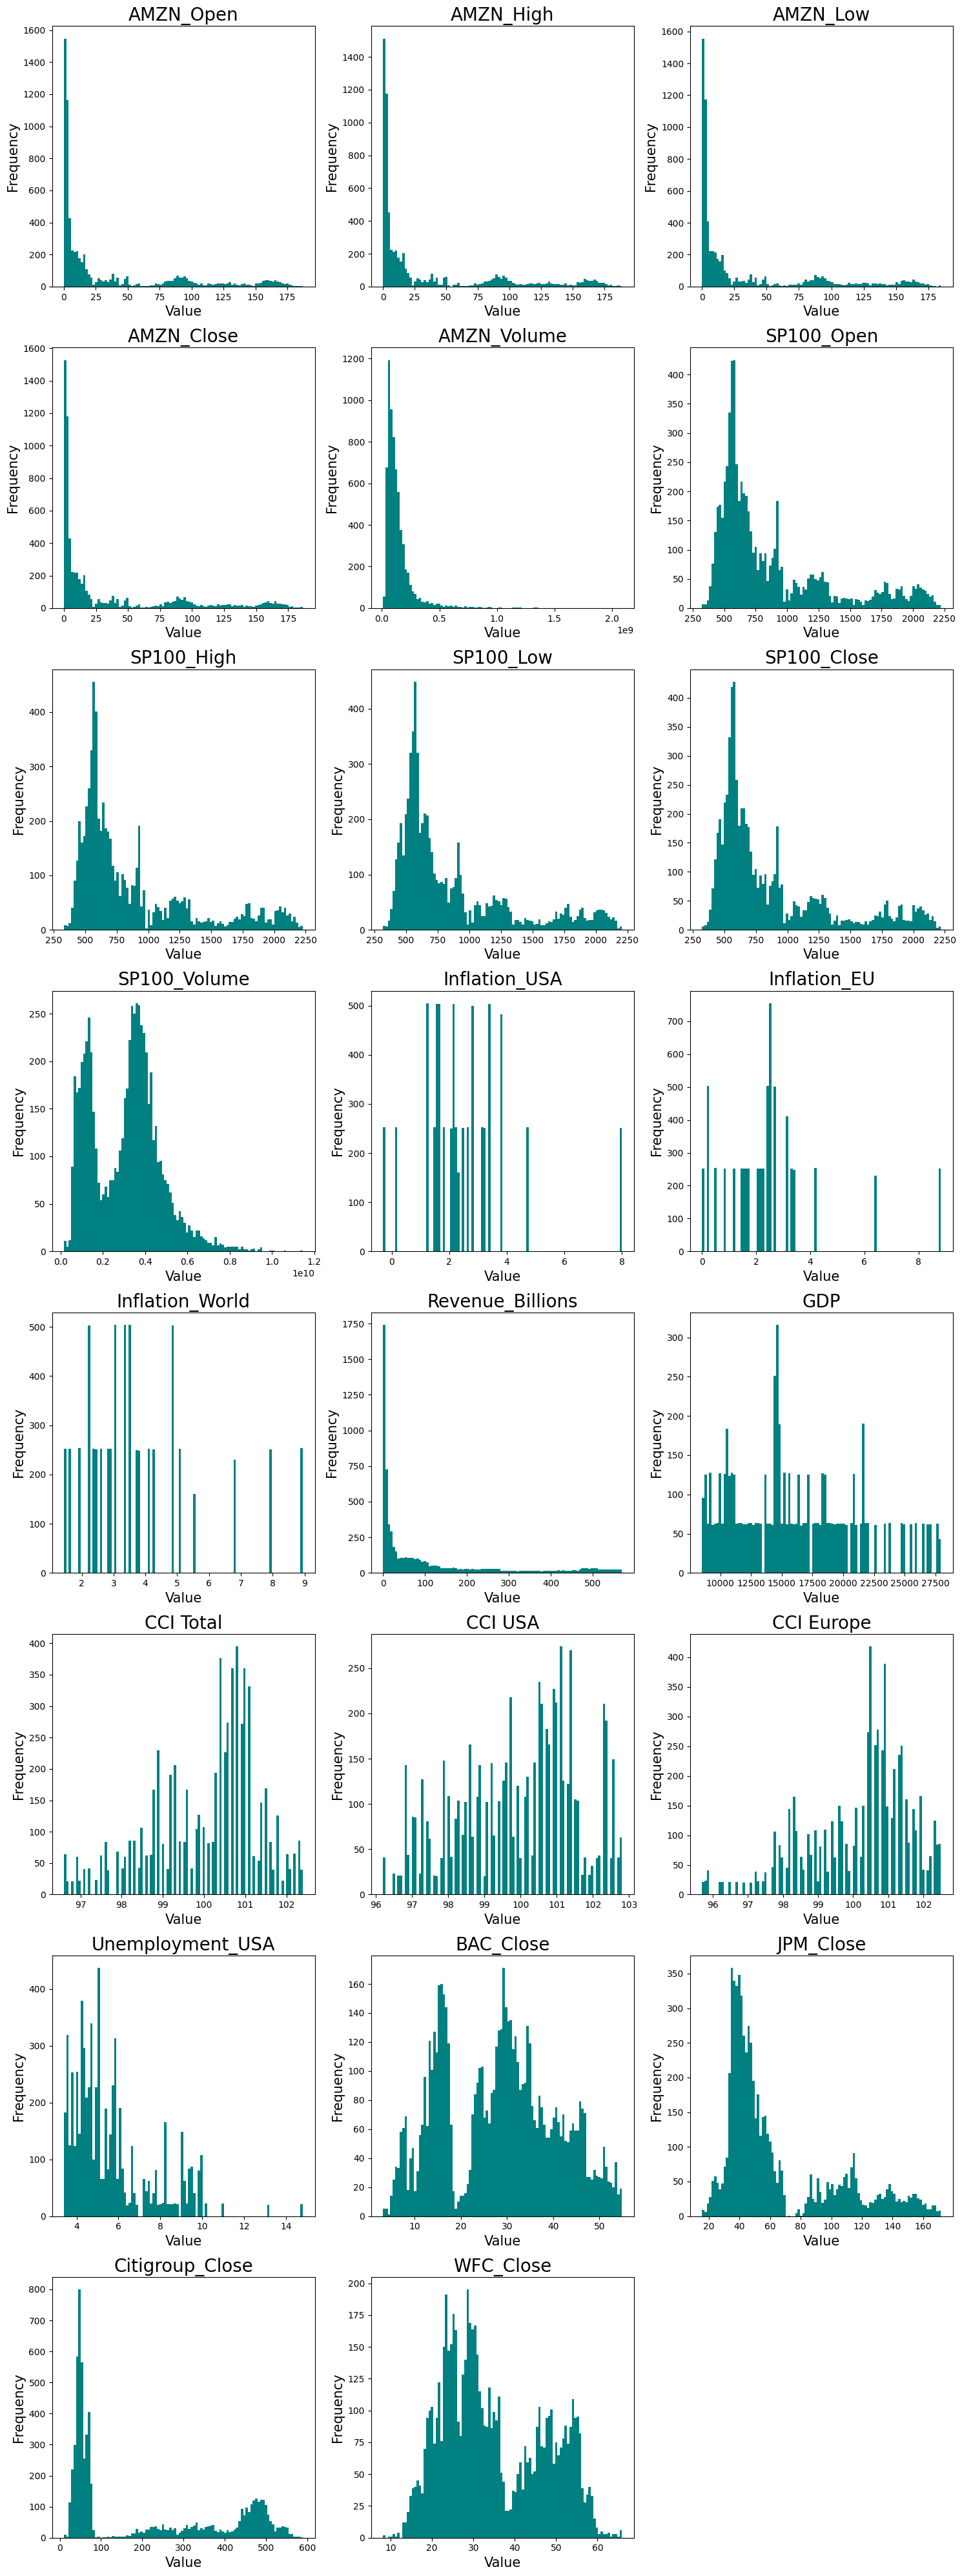

In [12]:
plot_histograms(data)

Several variables have a right-skewed distribution (positive skewness).
We can try to logarithmize variables with a skewed distribution.

#### Variables transformation
We choose variables with a right-skewed distribution for logarithmization:

columns_to_log = ['AMZN_Open', 'AMZN_High', 'AMZN_Low', 'AMZN_Close', 'AMZN_Volume', 'SP100_Open', 'SP100_High',
                  'SP100_Low', 'SP100_Close', 'SP100_Volume', 'Revenue_Billions', 'Unemployment_USA', 'JPM_Close', 'Citigroup_Close']

for col in columns_to_log:
    data[col] = np.log(data[col])

plot_histograms(data)


<p style="color:#808080;">
    Zamiast logarymu można wziąć Boxa-Coxa, ale wykresy np. 'AMZN_Volume' i 'Citigroup_Close' wyszły gorzej niż z logarytmu.
</p>
<p style="color:#808080;">
    from scipy.stats import boxcox<br />
    fitted_data, fitted_lambda = stats.boxcox(original_data)
</p>

### Boxplots

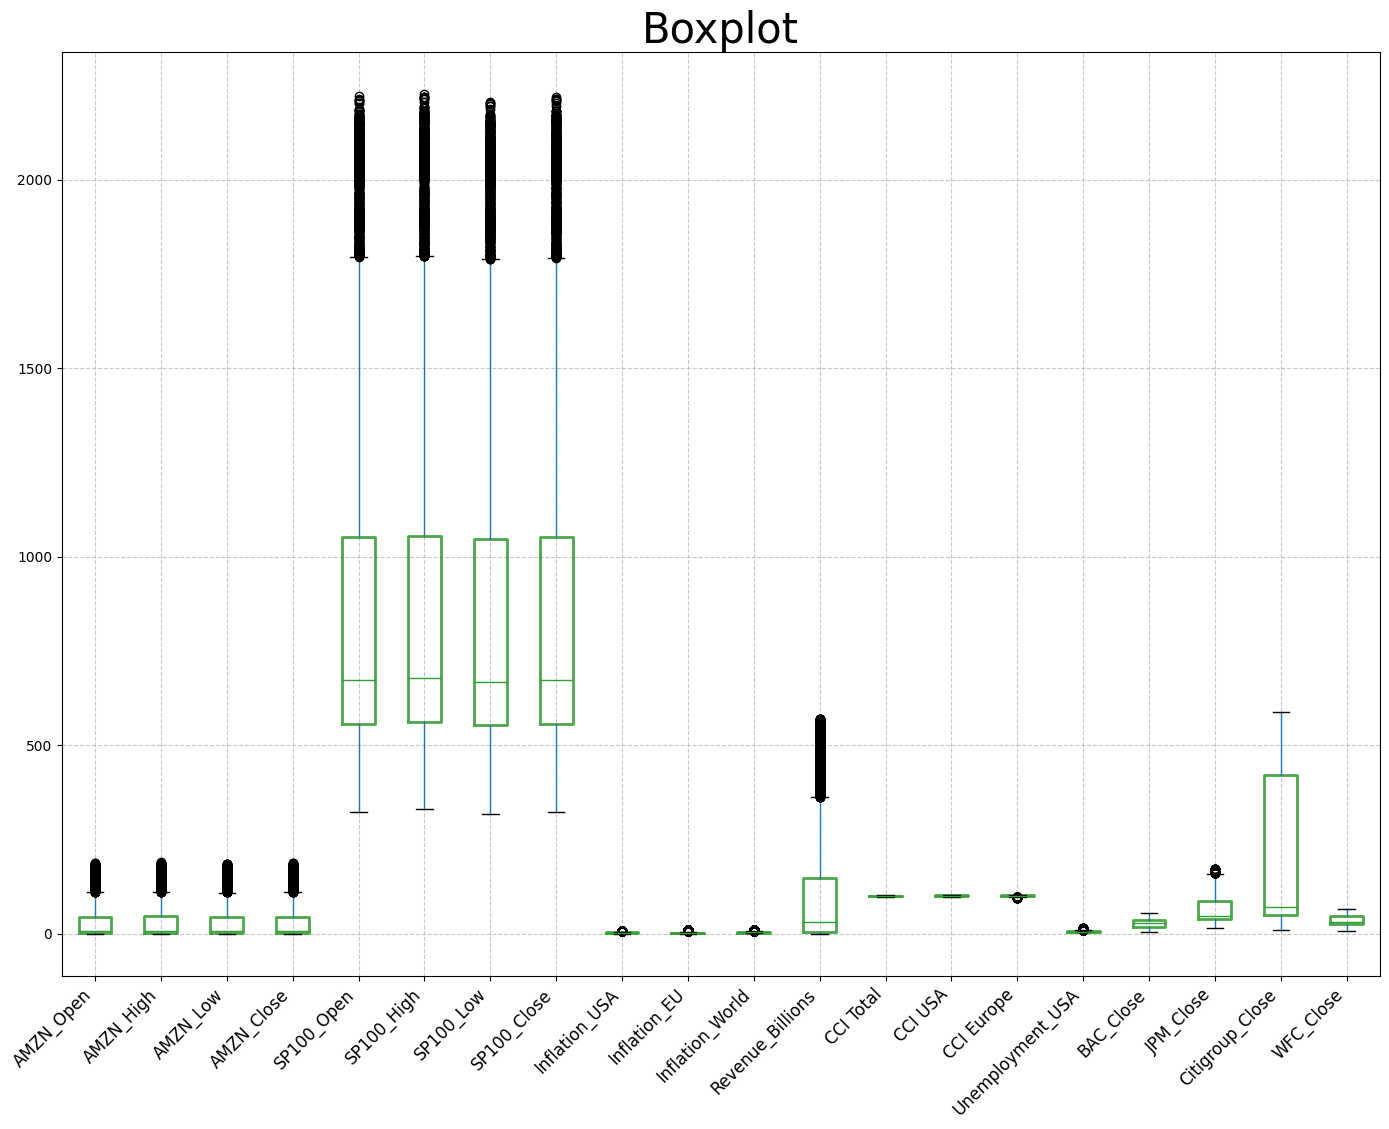

In [14]:
plt.figure(figsize=(17, 12))
boxprops = dict(linestyle='-', linewidth=2, color='green', alpha=0.7)
data2 = data.drop(columns=['AMZN_Volume', 'SP100_Volume', 'GDP'], errors='ignore')
data2.boxplot(boxprops=boxprops)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right',size=12)
plt.title('Boxplot',size = 30)
plt.show()

### Pairplot

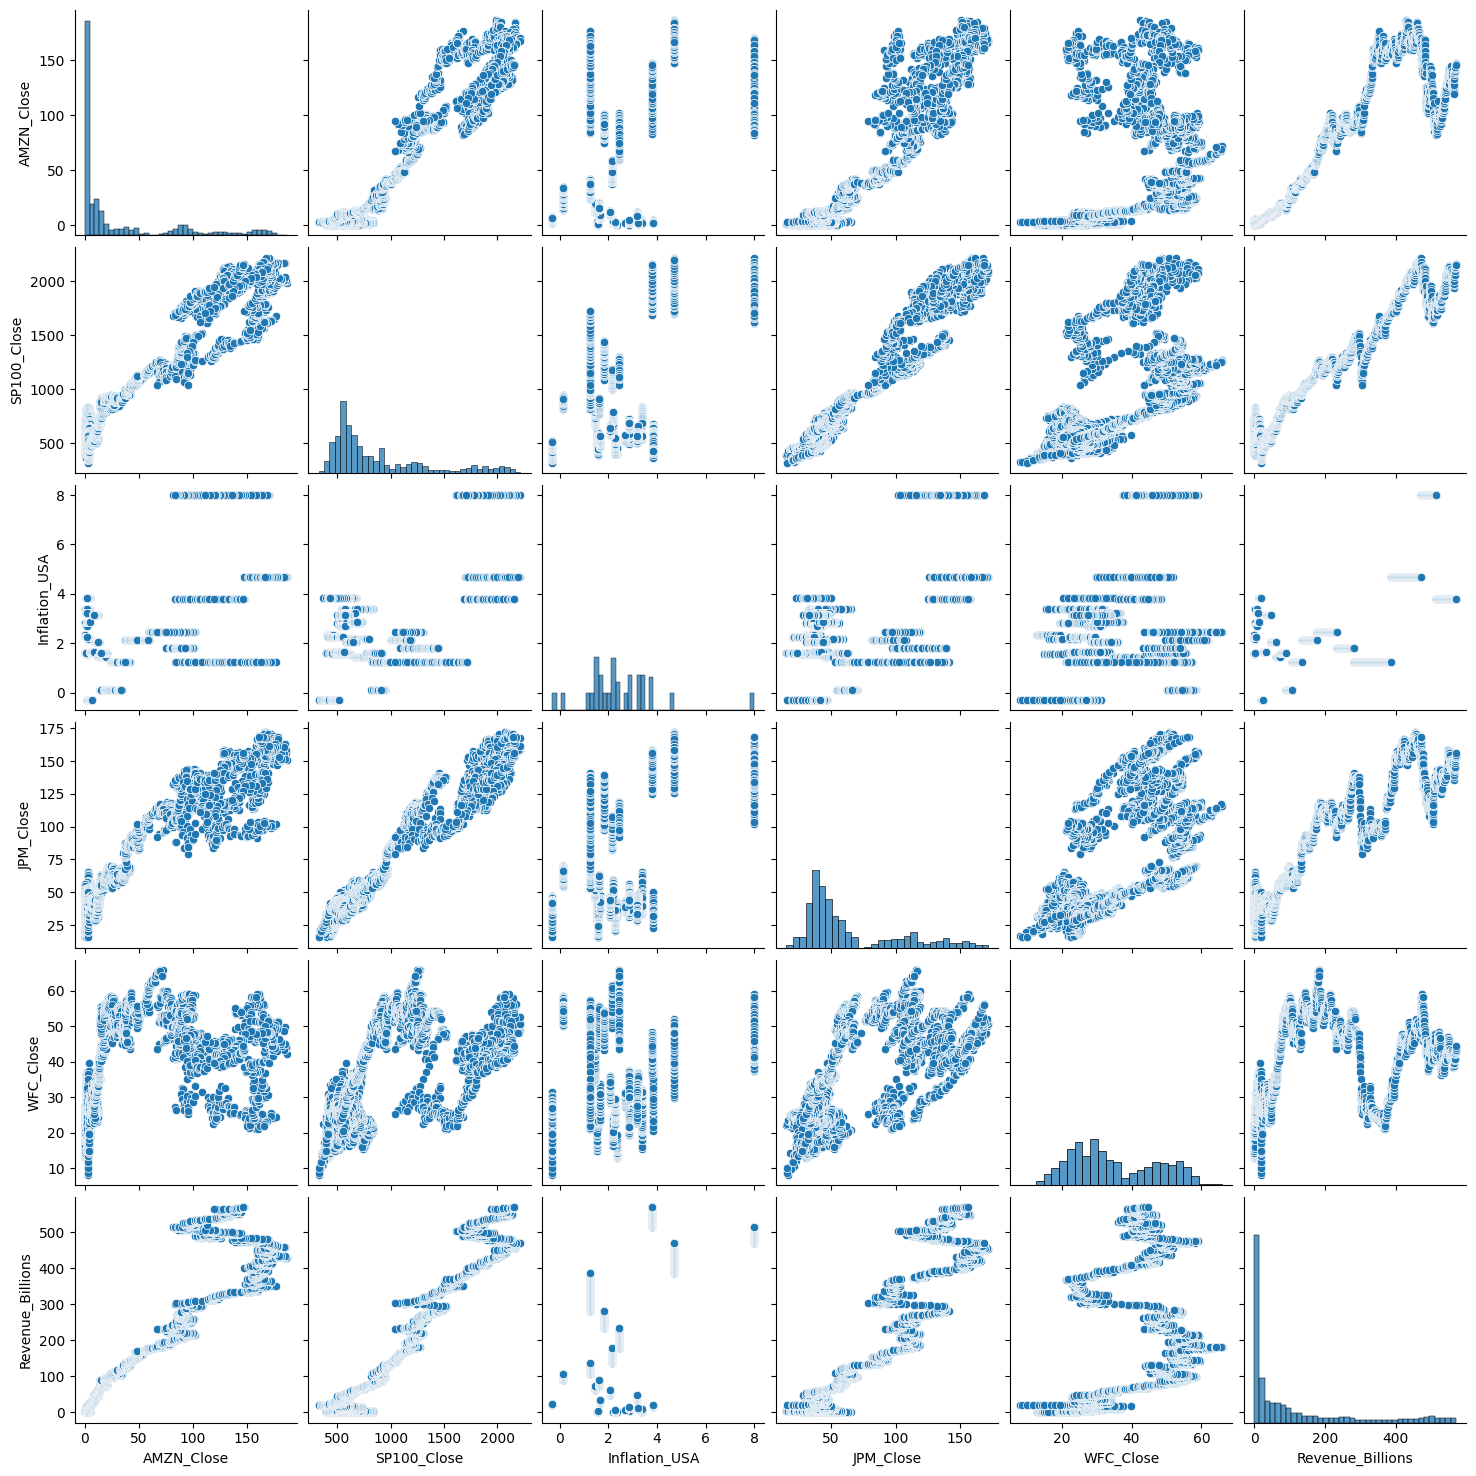

In [15]:
names1 = ['AMZN_Close', 'SP100_Close', 'Inflation_USA', 'JPM_Close', 'WFC_Close', 'Revenue_Billions']
sns.pairplot(data, vars=names1)
plt.show()

If the graph is slanted, the histograms of kernel density plots show the distribution of individual variables.

If the scatter plot is in the lower triangle, it shows the relationship between pairs of variables.

If the scatter plots above and below the diagonal are mirror images, indicating symmetry.

If the histograms are more centered, it represents the locations of peaks. Skewness is illustrated by observing whether the histogram is symmetrical or skewed to the left or right.

### Correlation Heatmap

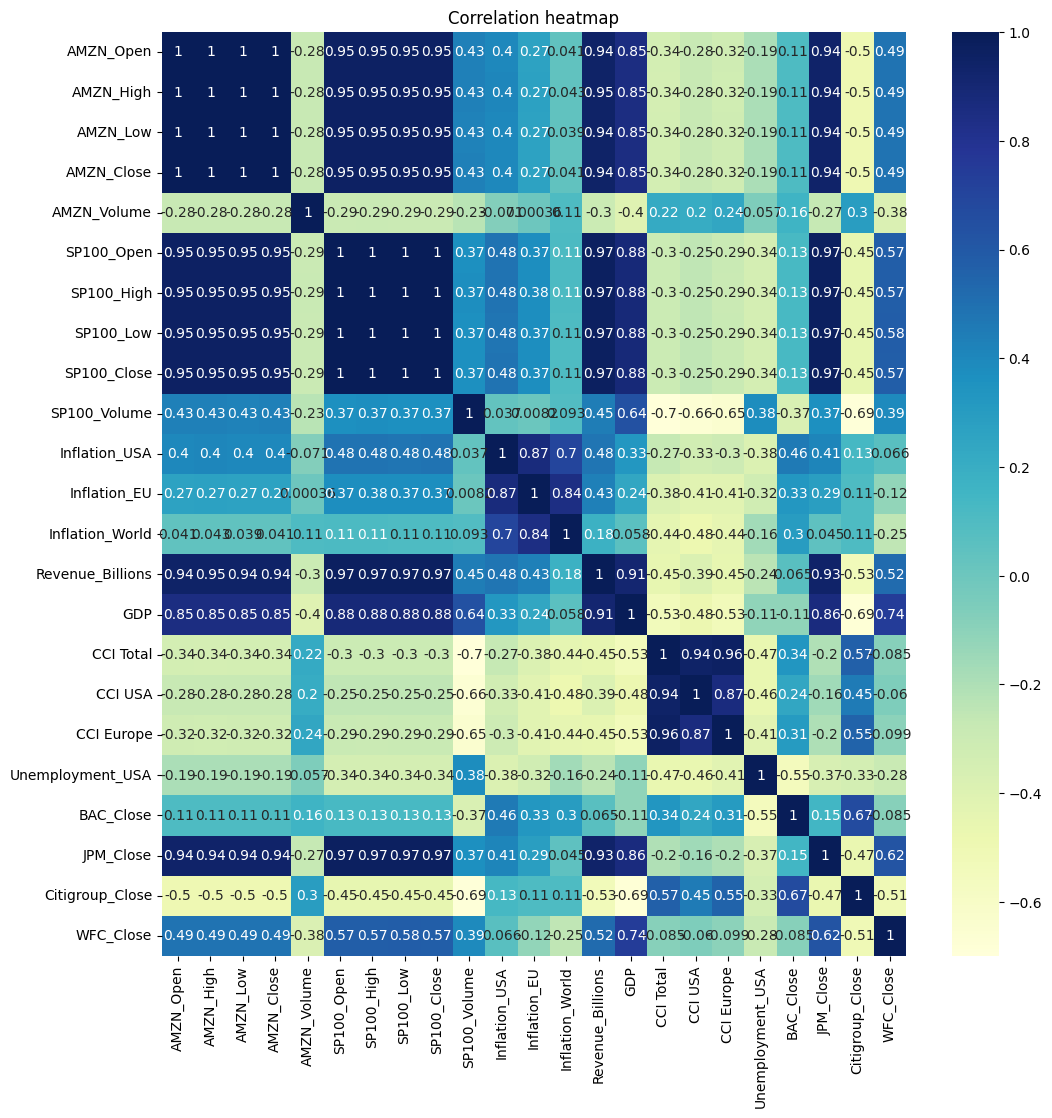

In [16]:
fig = plt.figure(figsize=(12,12))
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation heatmap')
plt.show()

The correlation heatmap for all variables is unreadable, so we will reduce the number of columns taken into account.
We can see that the AMZN variables have a correlation of 1 with each other, the same is true for sp100.

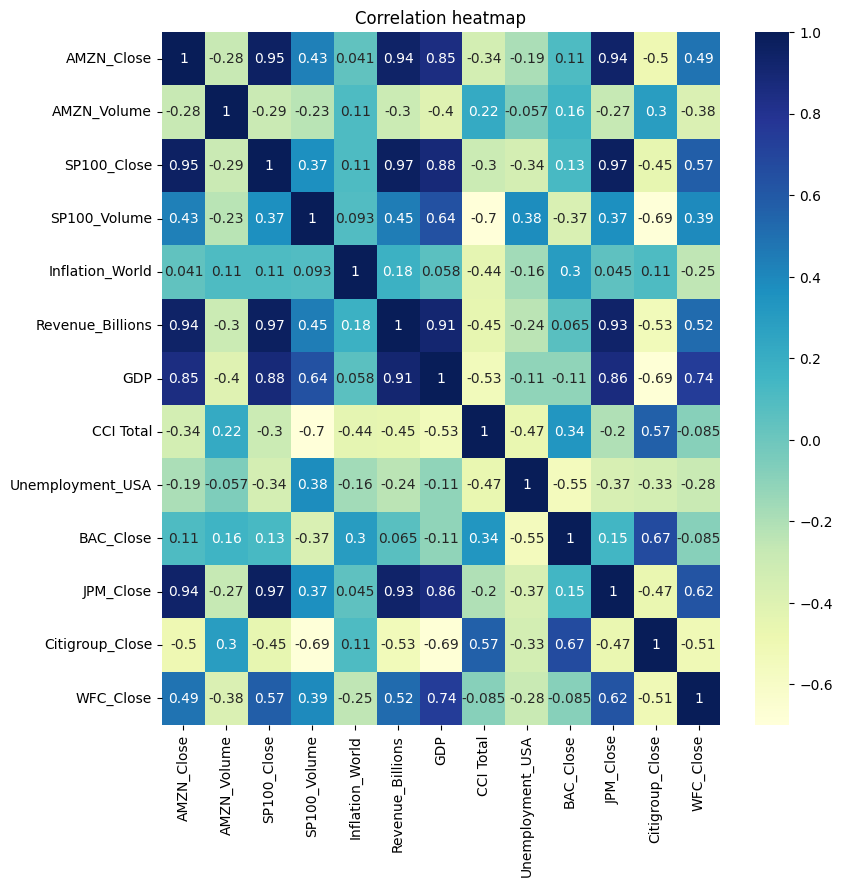

In [17]:
names = ['AMZN_Close', 'AMZN_Volume', 'SP100_Close', 'SP100_Volume', 'Inflation_World', 'Revenue_Billions',
         'GDP', 'CCI Total', 'Unemployment_USA', 'BAC_Close', 'JPM_Close', 'Citigroup_Close', 'WFC_Close']
fig = plt.figure(figsize=(9,9))
sns.heatmap(data[names].corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation heatmap')
plt.show()

The greatest correlation AMZN_Close has with Revenue_Billions and GDP, then with SP100_Close, JPM_Close, WFC_Close and SP100_Volume.

### Graphs of variables versus time

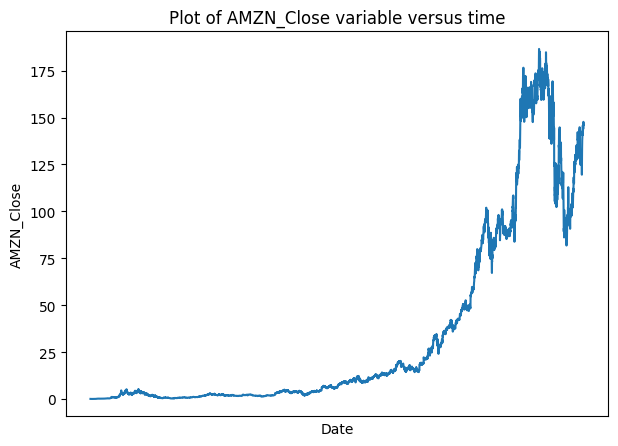

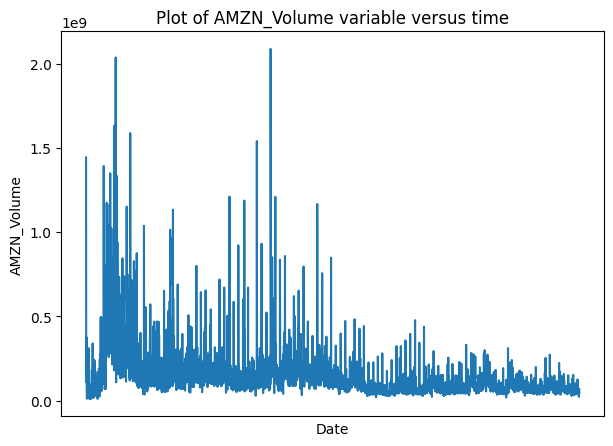

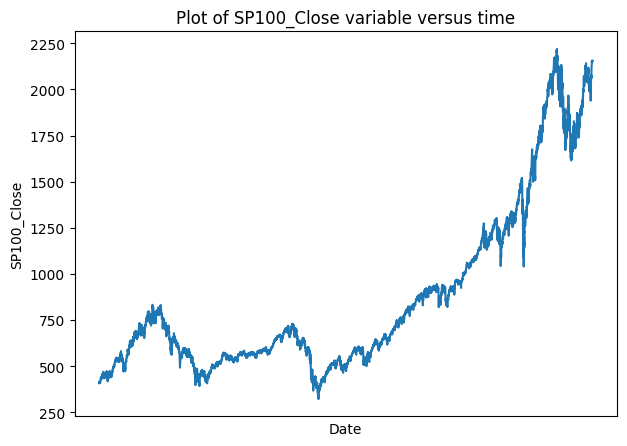

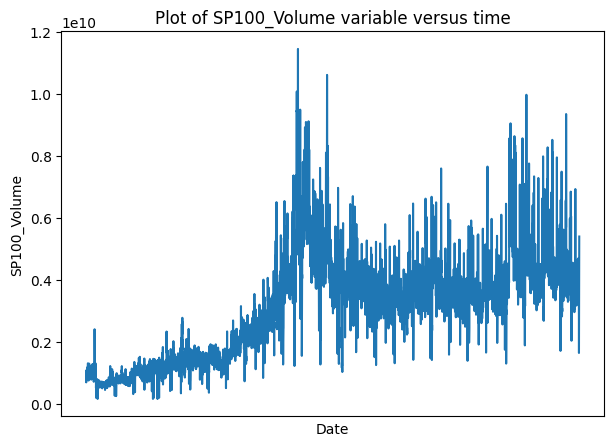

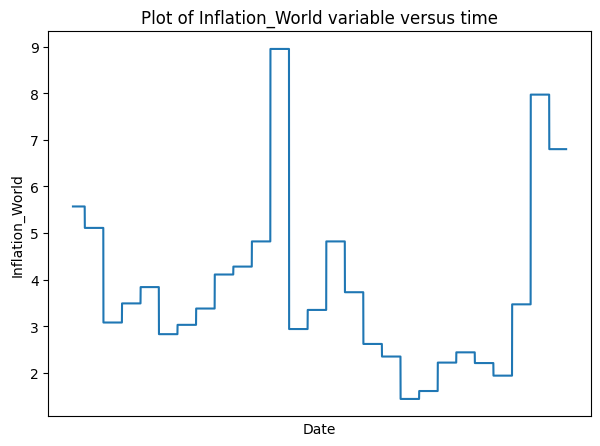

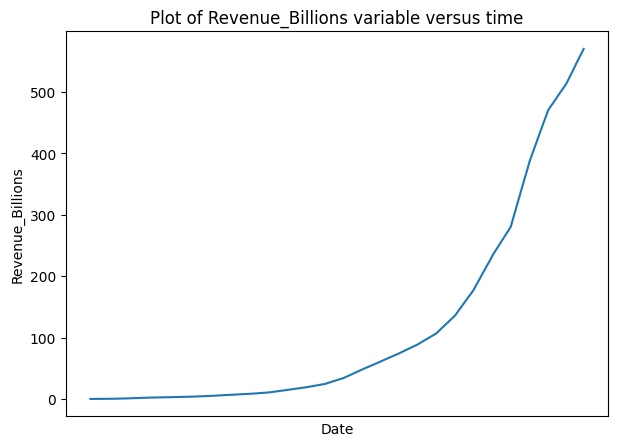

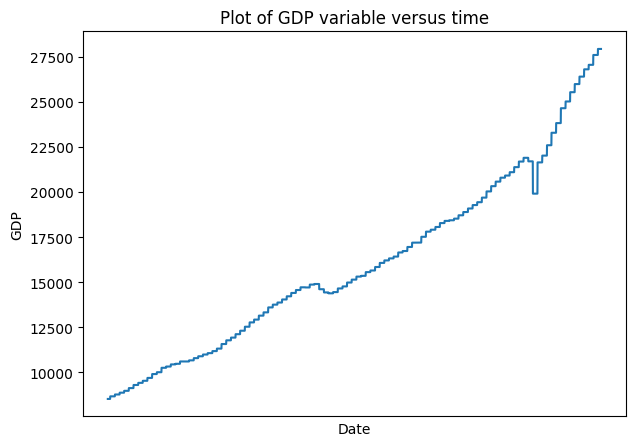

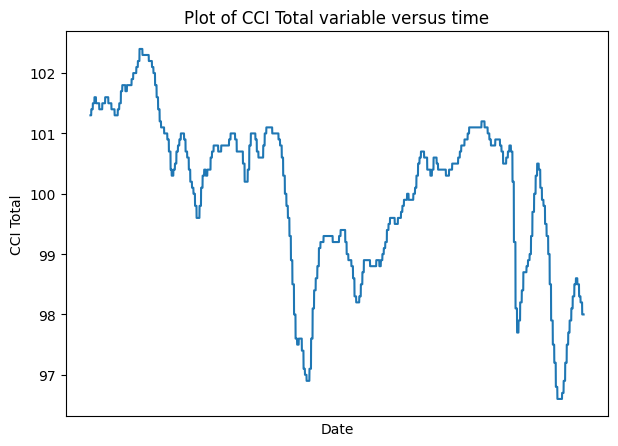

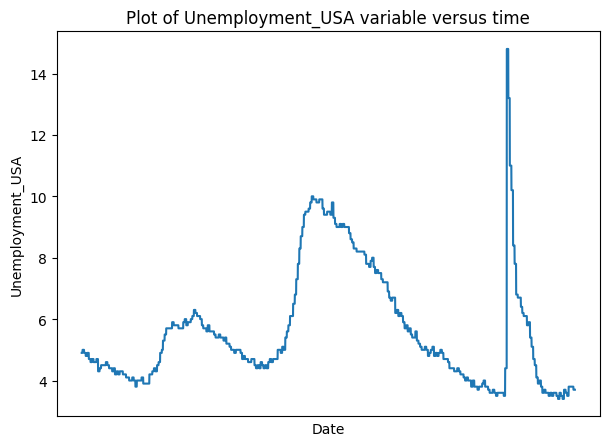

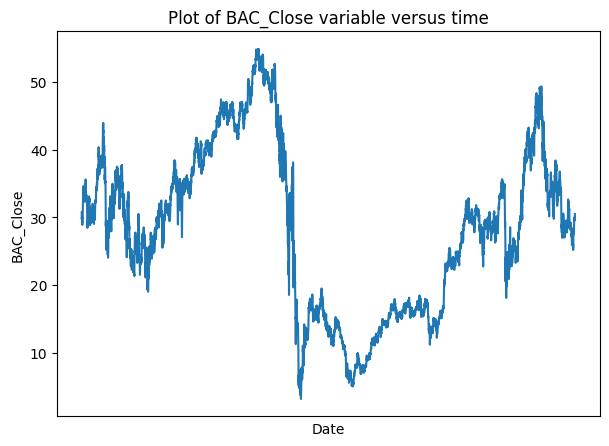

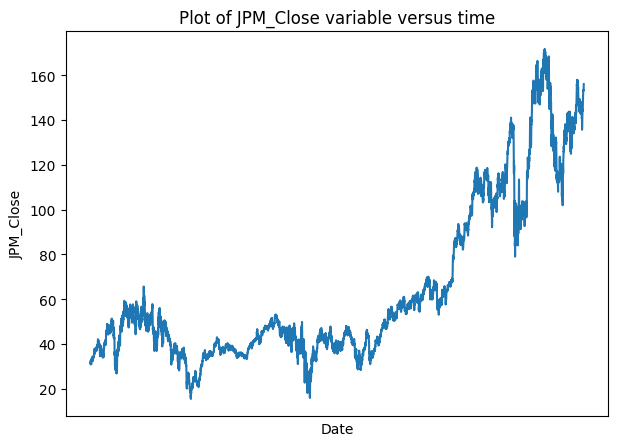

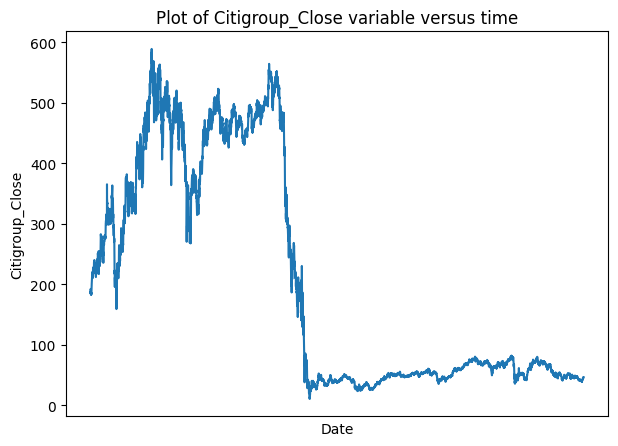

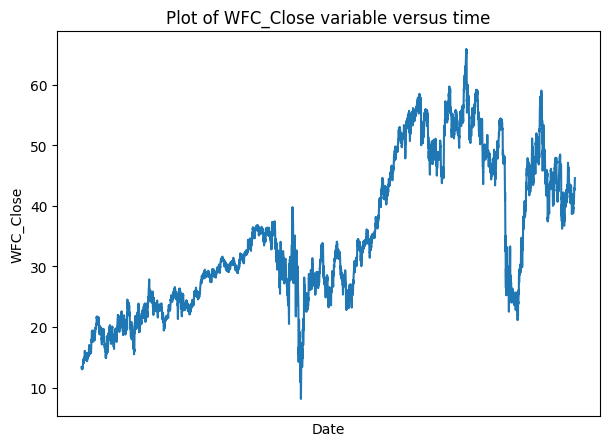

In [22]:
for name in names:
    plt.figure(figsize=(7,5))
    plt.plot(data[name])
    plt.title('Plot of {} variable versus time'.format(name))
    plt.xticks([])
    plt.xlabel('Date')
    plt.ylabel(name)
    plt.show()

# Prediction of future Amazon.com stock prices

### Splitting data into train and test datasets

**Pytanie:** Biorąc podstawowe dane i dając y=AMZN_CLose i pozostałe dane jako X może pojawić się problem. AMZN_Close, AMZN_Open, AMZN_High, AMZN_Low mają bardzo zbliżone wartości. Modele mogą zatem skupiać się na High Low i Open przy predykcji Close. Nam chyba bardziej zależałoby na przewidywaniu Close przy pomocy innych czynników. Czy jest to prawidłowe myślenie? Czy możemy brać dane BEZ Open, High i Low?

In [31]:
df = data.drop(columns=['AMZN_Open', 'AMZN_High', 'AMZN_Low'])
split_index = int(len(df) * 0.93)

train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

In [32]:
y_train = train_data['AMZN_Close']
X_train = train_data.drop(columns = ['AMZN_Close'])
X_train.set_index(train_data.index, inplace = True)
y_test = test_data['AMZN_Close']
X_test = test_data.drop(columns = ['AMZN_Close'])
X_test.set_index(test_data.index, inplace = True)

In [33]:
X_train

,AMZN_Volume,SP100_Open,SP100_High,SP100_Low,SP100_Close,SP100_Volume,Inflation_USA,Inflation_EU,Inflation_World,Revenue_Billions,GDP,CCI Total,CCI USA,CCI Europe,Unemployment_USA,BAC_Close,JPM_Close,Citigroup_Close,WFC_Close
Date,,,,,,,,,,,,,,,,,,,
1997-05-15,1.443120e+09,410.994995,414.295013,409.625000,414.200012,9.163600e+08,2.34,3.11,5.57,0.064587,8518.825,101.3,102.0,100.8,4.9,30.750000,32.375000,186.666672,13.406250
1997-05-16,2.940000e+08,414.200012,414.200012,406.279999,406.279999,9.735600e+08,2.34,3.11,5.57,0.064948,8518.825,101.3,102.0,100.8,4.9,30.187500,31.208332,184.166672,13.125000
1997-05-19,1.221360e+08,406.279999,410.350006,406.279999,409.230011,6.902800e+08,2.34,3.11,5.57,0.066034,8518.825,101.3,102.0,100.8,4.9,29.687500,30.875000,185.833328,13.187500
1997-05-20,1.093440e+08,409.230011,414.480011,405.890015,414.160004,9.017000e+08,2.34,3.11,5.57,0.066395,8518.825,101.3,102.0,100.8,4.9,30.062500,32.166668,192.083328,13.406250
1997-05-21,3.770640e+08,414.160004,416.739990,411.035004,413.140015,1.081460e+09,2.34,3.11,5.57,0.066757,8518.825,101.3,102.0,100.8,4.9,29.250000,31.041668,186.250000,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,5.218800e+07,2185.139893,2189.100098,2142.050049,2146.000000,4.251730e+09,8.00,8.83,7.97,471.392822,25029.116,99.0,97.7,99.4,4.0,48.759998,168.229996,67.779999,56.000000
2022-01-14,4.597400e+07,2135.830078,2151.169922,2129.570068,2149.929932,4.338490e+09,8.00,8.83,7.97,471.513808,25029.116,99.0,97.7,99.4,4.0,47.910000,157.889999,66.930000,58.060001
2022-01-18,6.729200e+07,2131.260010,2131.260010,2106.419922,2110.129883,4.748700e+09,8.00,8.83,7.97,471.997753,25029.116,99.0,97.7,99.4,4.0,46.259998,151.270004,65.300003,56.689999


### Data standardization

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## PRO8L3M, CZY NATURA RYNKU?

### Principal component analysis

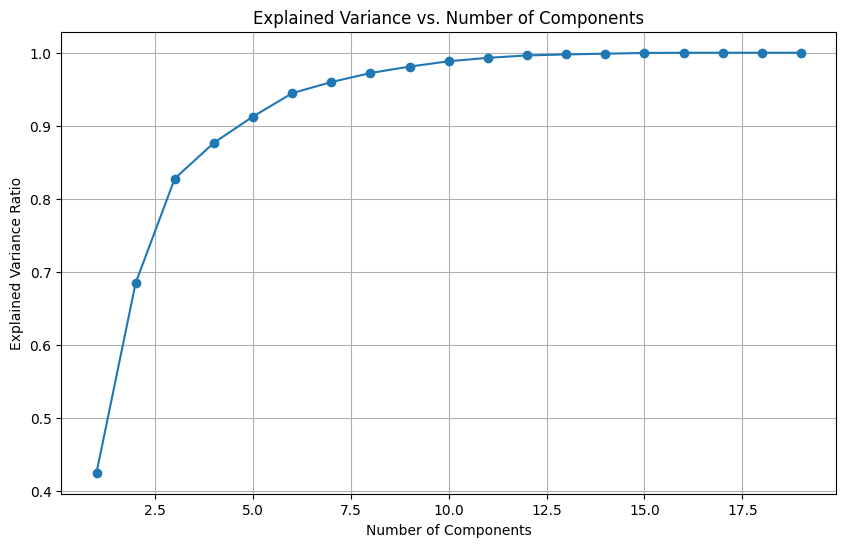

In [28]:
pca = PCA()
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [36]:
# Perform PCA on the training data
pca = PCA(n_components=5)
X_train_feat = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train_feat, index=train_data.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Apply the same PCA transformation to both training and test data
X_test_feat = pca.transform(X_test)
X_test = pd.DataFrame(X_test_feat, index=test_data.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [37]:
X_train

,PC1,PC2,PC3,PC4,PC5
Date,,,,,
1997-05-15,-4.793663,-1.573140,0.467391,7.981933,2.692099
1997-05-16,-3.717194,-0.971789,0.230049,0.885839,-0.089845
1997-05-19,-3.597611,-0.923348,0.167717,-0.188845,-0.559057
1997-05-20,-3.542218,-0.907833,0.191373,-0.264628,-0.546477
1997-05-21,-3.772622,-0.976980,0.240498,1.411118,0.118087
...,...,...,...,...,...
2022-01-13,7.362590,-3.035318,9.750459,-0.515178,0.391676
2022-01-14,7.240427,-2.919214,9.664574,-0.652736,0.526833
2022-01-18,7.110048,-2.747296,9.639858,-0.506032,0.623136


## Linear Regression

In [ ]:
# Create a linear regression model
linear_model = LinearRegression()

In [ ]:
# Train the model
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict on the test set
y_pred = linear_model.predict(X_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 107.0147777920649


In [ ]:
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Predicted Stock Price'])

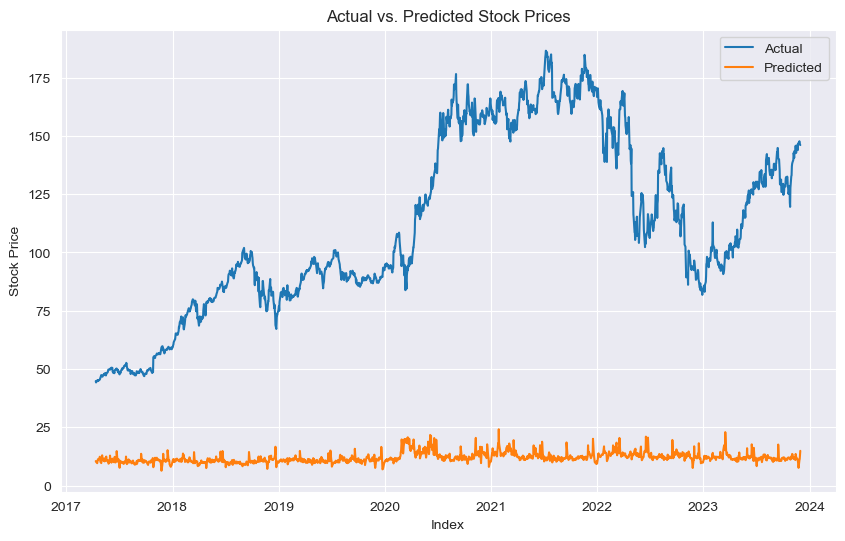

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

## SVR (Support Vector Regression)

In [ ]:
# Create SVR model
svm_model = SVR(kernel='linear')

In [ ]:
# Train the model
svm_model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

## Random Forest Regression

In [ ]:
# Create Random Forest Regression model
rf = RandomForestClassifier()

In [ ]:
# Train the model
rf_model = rf.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

## Gradient Boosting Regressor

In [56]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = pd.DataFrame(pred, index=X_test.index, columns=['Predicted Stock Price'])
score = reg.score(X_test, y_test)
print (score)

-6.250602457180039


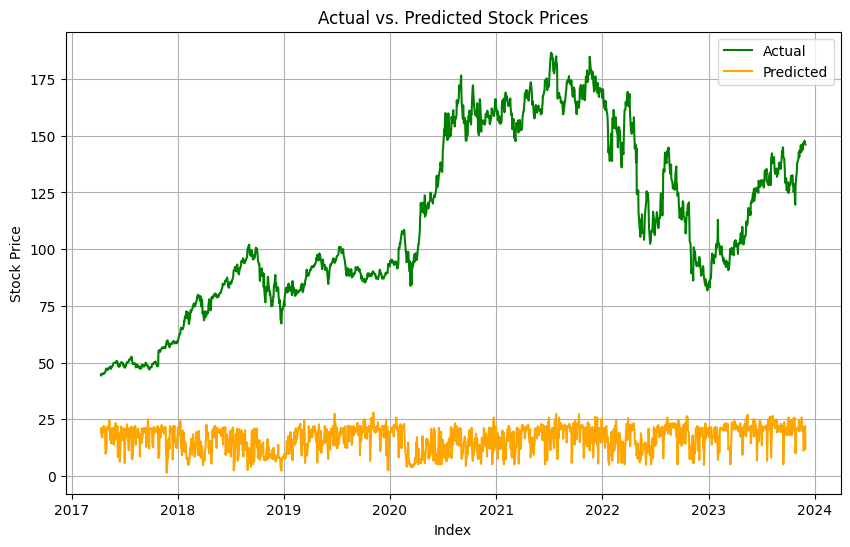

In [57]:
plt.figure(figsize=(10, 6))
plt.plot( y_test, color='green', label='Actual')
plt.plot( pred, color='orange', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

## ~~LSTM (Long-Short Term Memory)~~

In [64]:
# Data normalization - czy potrzebne, bo jest już StandardScaler()
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_normalized = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# LSTM model definition
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2])))
model.add(Dropout(0.2))  # 20% of the neurons will be randomly "dropped out" during training
model.add(Dense(1))

# Model build
model.compile(optimizer=Adam(), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=2)  # stop training when the validation loss stops improving
history = model.fit(X_train_normalized, y_train, epochs=100, batch_size=72, validation_data=(X_test_normalized, y_test), verbose=2, shuffle=True, callbacks=[early_stop])
# Predict on the test set
y_pred = model.predict(X_test_normalized)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Epoch 1/100
70/70 - 13s - loss: 126.0760 - val_loss: 11209.3691 - 13s/epoch - 185ms/step
Epoch 2/100
70/70 - 1s - loss: 62.2400 - val_loss: 8986.6055 - 956ms/epoch - 14ms/step
Epoch 3/100
70/70 - 1s - loss: 23.0175 - val_loss: 7405.1279 - 1s/epoch - 17ms/step
Epoch 4/100
70/70 - 1s - loss: 13.8308 - val_loss: 6978.7100 - 1s/epoch - 15ms/step
Epoch 5/100
70/70 - 1s - loss: 12.4440 - val_loss: 6756.0566 - 865ms/epoch - 12ms/step
Epoch 6/100
70/70 - 1s - loss: 11.3740 - val_loss: 6541.6772 - 759ms/epoch - 11ms/step
Epoch 7/100
70/70 - 1s - loss: 10.8903 - val_loss: 6340.6064 - 761ms/epoch - 11ms/step
Epoch 8/100
70/70 - 1s - loss: 10.0445 - val_loss: 6167.0508 - 773ms/epoch - 11ms/step
Epoch 9/100
70/70 - 1s - loss: 9.4034 - val_loss: 5994.2783 - 739ms/epoch - 11ms/step
Epoch 10/100
70/70 - 1s - loss: 8.6485 - val_loss: 5784.2070 - 839ms/epoch - 12ms/step
Epoch 11/100
70/70 - 1s - loss: 8.2183 - val_loss: 5617.7031 - 658ms/epoch - 9ms/step
Epoch 12/100
70/70 - 1s - loss: 7.6488 - val_loss

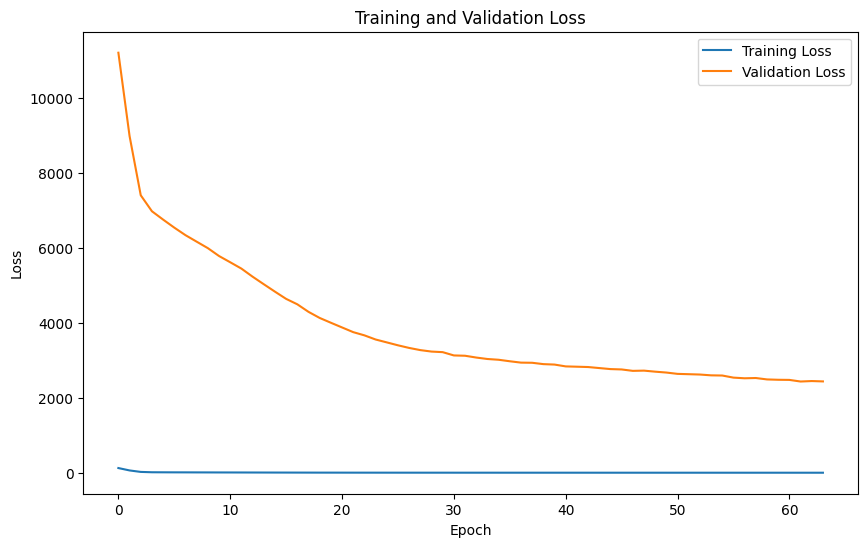

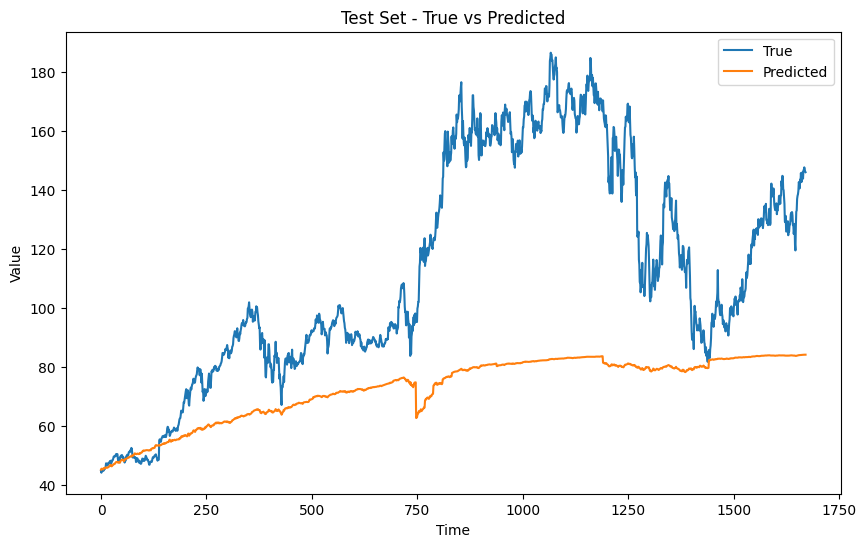

In [65]:
# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Test Set - True vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## GRU (Gated Recurrent Units)

In [ ]:
# gru models

## ~~CNN (Convolutional Neural Network)~~

In [ ]:
# cnn models

## ARIMA (Auto-Regressive Integrated Moving Average)

In [ ]:
# arima models

## Exponential Smoothing
Example: https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html

In [ ]:
# one of the exponential smoothing models

## LOWESS (Locally-Weighted Scatterplot Smoothing)
Example: https://james-brennan.github.io/posts/lowess_conf/

In [ ]:
# lowess models

## Kernel Weight?

In [ ]:
# kernel weight models

# Best model identification

In [ ]:
# the best model is: (to be continued...)

# Real-time data model application

In [ ]:
# application of the best model to the real time data (january-may 2024)

# What does the future hold...?

In [ ]:
# prediction for the next 2 years